In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline


In [17]:
# import mc data file
mcfile = 'mc_data/mc_data_rs100_run2.npy'
# mcfile = 'mc_data/testing.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 'num_dsa', 'den_dsa'])


In [19]:
# add relevant columns

mc_df['A_LL'] = mc_df['num_dsa']/mc_df['den_dsa']
mc_df['<cos(phi_kp)>'] = np.cos(mc_df['phi_kp'])*mc_df['A_LL']
mc_df['<cos(phi_Dp)>'] = np.cos(mc_df['phi_Dp'])*mc_df['A_LL']
mc_df['<cos(phi_kp)cos(phi_Dp)>'] = np.cos(mc_df['phi_kp'])*np.cos(mc_df['phi_Dp'])*mc_df['A_LL']
mc_df['<sin(phi_kp)sin(phi_Dp)>'] = np.sin(mc_df['phi_kp'])*np.sin(mc_df['phi_Dp'])*mc_df['A_LL']


In [27]:
mc_df.tail()

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,num_dsa,den_dsa,A_LL,<cos(phi_kp)>,<cos(phi_Dp)>,<cos(phi_kp)cos(phi_Dp)>,<sin(phi_kp)sin(phi_Dp)>
499995,10000.0,6.525254,0.006242,1.813257,12.538740,0.659111,0.682150,1.590662,2.913783,-37.951362,860.001077,-0.044129,0.000877,0.042989,-0.000854,-0.009964
499996,10000.0,7.466823,0.006048,0.291349,6.140865,0.634113,0.921778,1.063779,0.103898,12655.719448,63150.032359,0.200407,0.097312,0.199326,0.096787,0.018170
499997,10000.0,7.269356,0.008960,0.229855,12.929777,0.378560,0.589759,2.160661,4.828227,-15.125594,535.867353,-0.028226,0.015701,-0.003262,0.001815,0.023299
499998,10000.0,8.213828,0.006869,1.744248,10.087748,0.544266,0.982185,1.051981,5.371258,158.200229,1848.821667,0.085568,0.042429,0.052387,0.025976,-0.058754
499999,10000.0,6.423107,0.004355,1.155517,8.497646,0.460296,0.947419,5.666509,0.907470,1007.234854,14599.688340,0.068990,0.056283,0.042480,0.034655,-0.031438


In [117]:
# function to plot histograms

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

labels = {'num_dsa': 'DSA',
         'den_dsa': 'Total',
         'A_LL': r'$A_{LL}$',
         '<cos(phi_kp)>': r'$\langle \cos(\phi_{kp}) \rangle$',
         '<cos(phi_Dp)>': r'$\langle \cos(\phi_{\Delta p}) \rangle$',
         '<cos(phi_kp)cos(phi_Dp)>': r'$\langle \cos(\phi_{kp}) \cos(\phi_{\Delta p}) \rangle$',
         '<sin(phi_kp)sin(phi_Dp)>': r'$\langle \sin(\phi_{kp}) \sin(\phi_{\Delta p}) \rangle$'
         }

def plot_histogram(df, plot_q, weights, constraints={}, **options):

    asp_ratio = 5/3
    psize = 4
    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(asp_ratio*psize, psize), gridspec_kw={'width_ratios': [5, 1]})

    # make bins
    range = [df[plot_q].min(), df[plot_q].max()]
    nbins = options.get('nbins', 10)
    bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
    bins = options.get('bins', np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width))

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
    fixed_df = df[mask]

    if fixed_df.empty:
        print('Error: selected dataframe is empty - constraints are too constraining')
        return

    for iw in weights: assert iw in list(df.columns), f'Error: option for weight {iw} not recognized'
    lumi = options.get('lumi', 10) # total integrated luminosity in fb^-1
    lumi *= options.get('efficiency', 1) # correct for detector efficiency

    colors = ['black', 'red', 'blue', 'green']

    # make plot data         
    for iw, weight in enumerate(weights):
        
        total_counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['den_dsa'])
        plot_counts, _ = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df[weight])
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])

        # ensure bins are properly averaged
        n_entries, _ = np.histogram(fixed_df[plot_q], bins=bins)
        plot_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(plot_counts, n_entries)])
        total_counts = np.array([icount/(bin_width*ientry) if ientry != 0 else 0 for icount, ientry in zip(total_counts, n_entries)])
        
        # errors are calculated for a given integrated luminosity (5% systematic error added per 1505.05783)
        if '_dsa' in weight: 
            stat_errors = np.sqrt(total_counts/lumi)
            sys_errors = 0.05*np.abs(plot_counts)
        else:  
            stat_errors = np.array([np.sqrt((1+ic)/(lumi*tc)) if tc != 0 else 0 for ic, tc in zip(plot_counts, total_counts)])
            sys_errors = 0.05*plot_counts
            
        total_errors = np.sqrt((stat_errors**2)+(sys_errors)**2)

        # make plot
        ax.errorbar(
            bin_centers, plot_counts, yerr=total_errors,
            fmt=options.get('fmt', 'o'), 
            capsize=3, elinewidth=0.5, capthick=0.5, color=colors[iw]
        )
        ax.step(bin_centers, plot_counts, where='mid', linestyle='-', color=colors[iw], label=labels[weight], linewidth=0.5)  
        
    ax.legend(frameon=False)

    # make info box for constraints
    info_text = fr'(Effective) Integrated luminosity: ${lumi}\,\, \mathrm{{fb}}^{{-1}}$'+'\n'
    info_text += 'Constraints:\n'
    for var, (low, high) in constraints.items():
        info_text += fr'$ {low} < {var} < {high}$'+'\n'
    ax_info.text(
        0.0, 0.0, info_text, 
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.3)
    )
    ax_info.set_axis_off()

    # set plot info
    if options.get('y_limits'): ax.set_ylim(options.get('y_limits'))
    # if options.get('x_limits'): 
    ax.set_xlim(options.get('x_limits', [plot_bins[0], plot_bins[-1]]))
    ax.set_title(options.get('title', ''))
    ax.set_ylabel(options.get('y_label', 'Frequency'), loc='top')
    ax.set_xlabel(options.get('x_label', fr'${plot_q}$'), loc='right')
    ax.set_yscale(options.get('y_scale', 'linear'))
    ax.set_xscale(options.get('x_scale', 'linear'))
    ax.tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
    ax.grid(options.get('grid', False)) 
    if options.get('zeroline', False): ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)



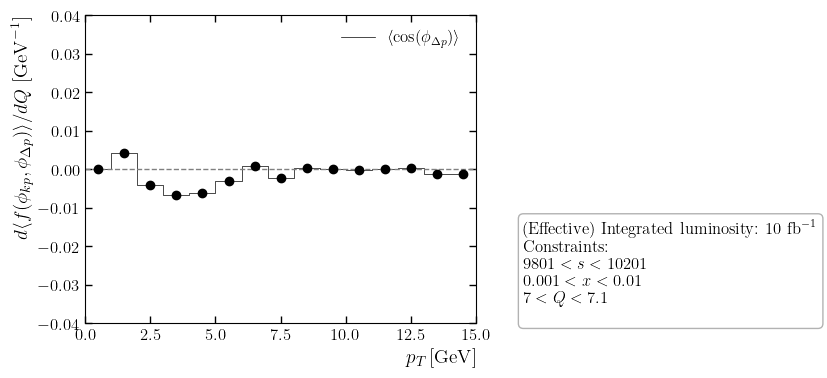

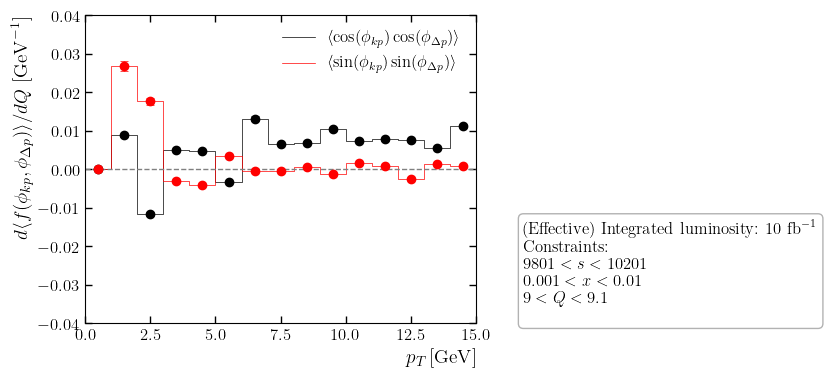

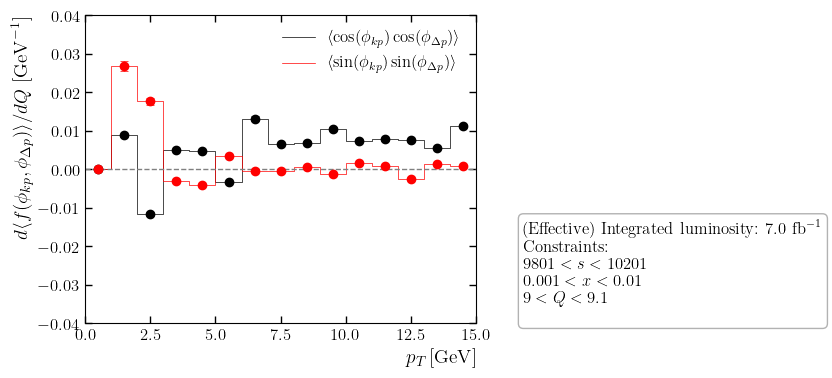

In [115]:
plot_s = 100
delta_s = 1


Q_bins = [i for i in range(15)]
pT_bins = [i for i in range(16)]

# plot_histogram(mc_df, 'Q', ['A_LL', ], 
#                    {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2],
#                     'x': [0.0010, 0.01],
#                     # 'Q': [6, 7]
#                    }, 
#                    lumi = 10,
#                    bins = Q_bins, 
#                    # y_scale='log', 
#                    # x_scale='log',
#                    x_limits = [5, 11], 
#                    # nbins = 10, 
#                    # y_limits = [0,0.35],
#                    zeroline = True,
#                    y_label=r'$dA_{LL} /dQ \,\,[\mathrm{GeV}^{-1}]$', x_label=r'$Q\, [\mathrm{GeV}]$')


plot_histogram(mc_df, 'pT', ['<cos(phi_Dp)>'], 
                   {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2],
                    'x': [0.0010, 0.01],
                    'Q': [7, 7.1]
                   }, 
                   lumi = 10,
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   # nbins = 10, 
                   bins = pT_bins, 
                   y_limits = [-0.04,0.04],
                   zeroline = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dQ \,\,[\mathrm{GeV}^{-1}]$', x_label=r'$p_T\, [\mathrm{GeV}]$')

plot_histogram(mc_df, 'pT', ['<cos(phi_kp)cos(phi_Dp)>', '<sin(phi_kp)sin(phi_Dp)>'], 
                   {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2],
                    'x': [0.0010, 0.01],
                    'Q': [9, 9.1]
                   }, 
                   lumi = 10,
                   efficiency = 1, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   # nbins = 10, 
                   y_limits = [-0.04,0.04],
                   zeroline = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dQ \,\,[\mathrm{GeV}^{-1}]$', x_label=r'$p_T\, [\mathrm{GeV}]$')


plot_histogram(mc_df, 'pT', ['<cos(phi_kp)cos(phi_Dp)>', '<sin(phi_kp)sin(phi_Dp)>'], 
                   {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2],
                    'x': [0.0010, 0.01],
                    'Q': [9, 9.1]
                   }, 
                   lumi = 10,
                   efficiency = 0.7, 
                   # y_scale='log', 
                   # x_scale='log',
                   # x_limits = [5, 11], 
                   bins = pT_bins,
                   # nbins = 10, 
                   y_limits = [-0.04,0.04],
                   zeroline = True,
                   y_label=r'$d \langle f(\phi_{kp}, \phi_{\Delta p}) \rangle /dQ \,\,[\mathrm{GeV}^{-1}]$', x_label=r'$p_T\, [\mathrm{GeV}]$')

